In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/steam/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/steam/test.csv")
#train = train[[user_review	user_suggestion]]

In [3]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 8.5 MB/s 
     |████████████████████████████████| 462 kB 35.4 MB/s 
     |████████████████████████████████| 1.8 MB 9.1 MB/s 
     |████████████████████████████████| 234 kB 29.1 MB/s 
     |████████████████████████████████| 1.2 MB 39.5 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 596 kB 31.1 MB/s 
     |████████████████████████████████| 352 kB 14.4 MB/s 
     |████████████████████████████████| 47.8 MB 87 kB/s 
     |████████████████████████████████| 1.1 MB 34.1 MB/s 
     |████████████████████████████████| 99 kB 5.0 MB/s 
     |████████████████████████████████| 90 kB 6.6 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=2ccfe295501f8b4a2917dd266df9731a6fe97065497f054a5470d311598fbe3f
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [5]:
test.head()

,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...


In [6]:
traindf = train[['user_review','user_suggestion']].copy()
testdf = test[['user_review']].copy()

In [7]:
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

     |████████████████████████████████| 3.8 MB 10.8 MB/s 
     |████████████████████████████████| 895 kB 52.6 MB/s 
     |████████████████████████████████| 6.5 MB 45.2 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 


In [46]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] 

    for e in examples:
        
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, 
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, 
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'user_review'
LABEL_COLUMN = 'user_suggestion'

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(traindf['user_review'],traindf['user_suggestion'], stratify=traindf['user_suggestion'],random_state=1234, test_size=0.2)

In [11]:
trdf = pd.DataFrame({'user_review':X_train,'user_suggestion':y_train})
vadf = pd.DataFrame({'user_review':X_test,'user_suggestion':y_test})

In [12]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(trdf, vadf, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history = model.fit(train_data, epochs=1, validation_data=validation_data)

876/876 [==============================] - 531s 573ms/step - loss: 0.2624 - accuracy: 0.8901 - val_loss: 0.2927 - val_accuracy: 0.8857


In [17]:
import sklearn
sen = len(X_test)

## Final model performance

In [48]:
pred_list=[]
for i in range(len(sen)):
  tf_batch = tokenizer(sen[i], max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = model(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  labels = ['Negative','Positive']
  label = tf.argmax(tf_predictions, axis=1)
  label = label.numpy()
  pred_list.append(label[0])

In [50]:
sklearn.metrics.f1_score(pred_list,y_test)

0.8998497746619929

In [52]:
sklearn.metrics.roc_auc_score(pred_list,y_test)

0.8835395263509005

In [53]:
sklearn.metrics.accuracy_score(pred_list,y_test)

0.8856816233209488

## Why epoch = 1 is final model?; Explanation of overfitting 

In [57]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history = model.fit(train_data, epochs=3, validation_data=validation_data)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
876/876 [==============================] - 533s 539ms/step - loss: 0.2627 - accuracy: 0.8924 - val_loss: 0.2971 - val_accuracy: 0.8840
Epoch 2/3
876/876 [==============================] - 469s 535ms/step - loss: 0.0720 - accuracy: 0.9760 - val_loss: 0.3863 - val_accuracy: 0.8825
Epoch 3/3
876/876 [==============================] - 470s 536ms/step - loss: 0.0303 - accuracy: 0.9901 - val_loss: 0.4602 - val_accuracy: 0.8823


In [58]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
final_accuracy = acc[-1]
final_loss = loss[-1]
final_val_acc = val_acc[-1]
final_val_loss = val_loss[-1]
print("final accuracy of train set:", round(final_accuracy,3))
print("final loss of train set:", round(final_loss,3))
print("final accuracy of test set:", round(final_val_acc,3))
print("final loss of tes set:", round(final_val_loss,3))

final accuracy of train set: 0.99
final loss of train set: 0.03
final accuracy of test set: 0.882
final loss of tes set: 0.46


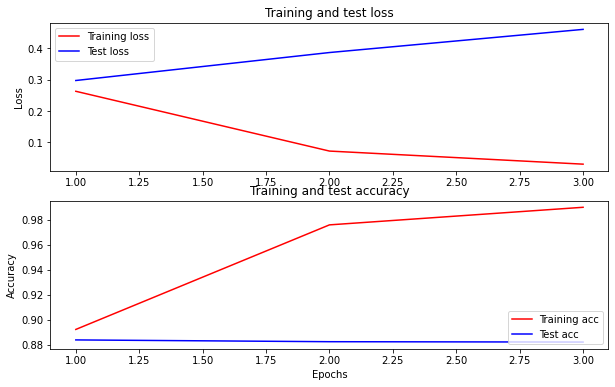

In [59]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Training and test loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Test acc')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

It is clear that if the number of epoch increase, there is more overfitting. So I decide to use model with epoch = 1